# Chapter 8

_Model based_ techniques require a model of the environment, such as:

1. Dynamic programming
2. Heuristic search.

_Model free_ techniques do not require a model, such as:

1. Temporal differences
2. Monte Carlo.

Model based techniques rely on planning whereas model-free techniques rely on learning.

Model based and model free techniques can be considered as a part of the same framework, just as Monte Carlo and TD learning can be thought of as specific examples of $n$-step TD learning.


## 8.1 Models and Planning

A _model_ of the environment produces the next state and reward for a given state-action pair.

For a stochastic environment, the model can produce either a full distribution over rewards and next states (called distribution models $p(s', r \mid s, a)$ or a single sample state-reward pair ($\hat{s}'$, $r$). Distribution models are more difficult to write and validate.

Models can be used to simulate experience.

_Planning_ refers to the use of a model to generate a new or improved policy.

_State-space_ planning, covered in this book, plans by valuing states explicitly and searching through possible successor states discovered by taking actions. _Plan-space_ planning involves considering the plan itself as the optimization target and covers approaches such as evolutionary methods.

Unified view of all state space planning:

1. All state space planning methods involve computing a value function over states.
2. Compute value functions by updates or backups applied to simulated experiences.

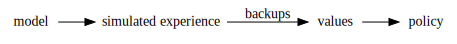

In [5]:
using GraphViz

graph = dot"""
digraph {
    rankdir=LR;
    node [shape=none];
    model -> "simulated experience";
    "simulated experience"-> values [label="backups"];
    values -> policy;
}
"""

GraphViz.layout!(graph, engine="dot")
graph

> The difference is that whereas planning uses simulated experience generated by a model, learning methods use real experience generated by the environment.

We can use learning methods to learn from simulated experience instead of planning methods.

E.g random sample tabular Q-learning.

In [6]:
function random_sample_tabular_q_learning(model, γ, α)
    Q = Dict((s, a) => 0.0 for s in 𝓢, a in A)
    while true
        s = rand(𝓢), a = rand(𝓐(s))
        r, sp = model(s, a)
        Q[(s, a)] += α*(r + γ*maximum(a -> Q[(s,a)], 𝓐(s)) - Q[(s, a)])
    end
end

random_sample_tabular_q_learning (generic function with 1 method)

## 8.2 Dyna: Integrated Planning, Acting and Learning

New information on the environment updates the model and therefore change planning.

Tradeoff between computation allocated to planning versus learning.

Dyna-Q, simple agent that plans online.

In [7]:
using Plots

𝓐 = [ :left, :up, :right, :down ]
𝓢 = setdiff([ (i, j) for i in 1:9, j in 1:6 ], [(3, i) for i in 3:5], [(8, i) for i in 4:6], [(6, 2)])
γ = 0.95

isterminal(s) = s == (9, 6)

function g(s, a)
    if a == :left
        sp = (clamp(s[1] - 1, 1, 9), s[2])
    elseif a == :up
        sp = (s[1], clamp(s[2] + 1, 1, 6))
    elseif a == :right
        sp = (clamp(s[1] + 1, 1, 9), s[2])
    elseif a == :down
        sp = (s[1], clamp(s[2] - 1, 1, 6))
    else
        error("Not a valid action")
    end
    sp = sp in 𝓢 ? sp : s
    r = sp == (9, 6) ? 1 : 0
    return sp, r
end

g (generic function with 1 method)

In [10]:
function dyna_q(episodes, n; ε=0.1, α=0.1)
    Q = Dict{Tuple,Float64}((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    model = Dict((s, a) => (0.0, s) for s in 𝓢, a in 𝓐)
    episode_steps = Int64[]
    transitions = []
    for episode in 1:episodes
        steps = 0
        s = (1, 4)
        while !isterminal(s)
            Qmax = maximum(a -> Q[(s, a)], 𝓐)
            a = rand() < ε ? rand(𝓐) : rand([a for a in 𝓐 if Q[(s, a)] == Qmax])
            sp, r = g(s, a)
            steps += 1
            Q[(s, a)] += α*(r + γ*maximum(a -> Q[(sp, a)], 𝓐) - Q[(s, a)])
            model[(s, a)] = r, sp
            push!(transitions, (sp, a))
            for i in 1:n
                st, at = rand(transitions)
                rt, spt = model[(st, at)]
                Q[(st, at)] += α*(rt + γ*maximum(a -> Q[(spt, a)], 𝓐) - Q[(st, at)])
            end
            s = sp
        end
        push!(episode_steps, steps)
    end
    
    return Q, episode_steps
end

dyna_q (generic function with 1 method)

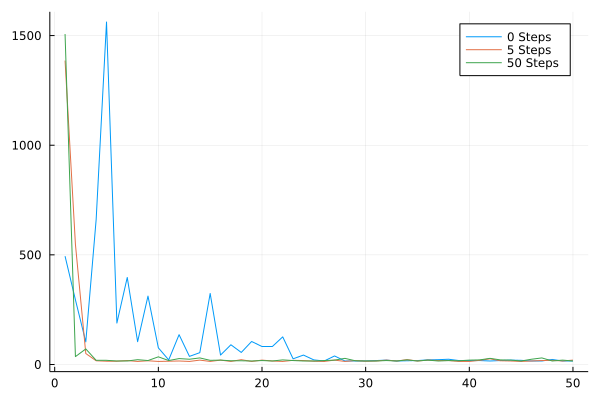

In [11]:
Q_0, steps_0 = dyna_q(50, 0)
Q_5, steps_5 = dyna_q(50, 5)
Q_50, steps_50 = dyna_q(50, 50)


plot([steps_0 steps_5 steps_50], label=["0 Steps" "5 Steps" "50 Steps"])

_Exercise 8.1_ The nonplanning method looks particularly poor in Figure 8.3 because it is a one-step method; a method using multi-step bootstrapping would do better. Do you think one of the multi-step bootstrapping methods from Chapter 7 could do as well as the Dyna method? Explain why or why not.

I do not think that any multi-step bootstrapping method will do as well as the Dyna method. This is because the multi-step bootstrapping method requires the episode to arrive at some reward (which occurs only once the agent has reached the end of the maze) before any action values are updated. While with a multi-step bootstrapping method, more actions in more states will be updated to be optimal, the Dyna-Q method will have learned the actual underlying model of the environment in much more detail, and so can simulate infinite experience with which to help it solve the problem.

## 8.3 When the Model Is Wrong

_Exercise 8.2_ Why did the Dyna agent with exploration bonus, Dyna-Q+, perform better in the first phase as well as in the second phase of the blocking and shortcut experiments?

The Dyna-Q+ agent performs better in the first experiment since it is additional accumulating reward from taking imaginary transitions (???).

The Dyna-Q+ agent performs better in the second experiment since it's exploration reveals the shortcut transition, which is then encoded into it's model, whereas vanilla Dyna-Q never attempts to revisit the shortcut transition again.

_Exercise 8.3_ Careful inspection of Figure 8.5 reveals that the difference between Dyna-Q+ and Dyna-Q narrowed slightly over the first part of the experiment. What is the reason for this?

This is because the added exploration penalty of Dyna-Q+ causes Dyna-Q to outperform it on an episode by episode basis.

_Exercise 8.4 (programming)_ The exploration bonus described above actually changes the estimated values of states and actions. Is this necessary? Suppose the bonus $\kappa\sqrt\tau$ was used not in updates, but solely in action selection. That is, suppose the action selected was always that for which $Q(S_t, a) + \kappa\sqrt\tau(S_t,a)$ was maximal. Carry out a gridworld experiment that tests and illustrates the strengths and weaknesses of this alternate approach.

In [14]:
function dyna_q_plus(𝓢, 𝓐, episodes, n; ε=0.1, α=0.1)
    Q = Dict{Tuple,Float64}((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    τ = Dict{Tuple,Float64}((s, a) => Inf for s in 𝓢, a in 𝓐)
    model = Dict((s, a) => (0.0, s) for s in 𝓢, a in 𝓐)
    episode_steps = Int64[]
    transitions = []
    for episode in 1:episodes
        steps = 0
        s = (1, 4)
        while !isterminal(s)
            Qmax = maximum(a -> Q[(s, a)], 𝓐)
            a = rand() < ε ? rand(𝓐) : rand([a for a in 𝓐 if Q[(s, a)] == Qmax])
            sp, r = g(s, a)
            steps += 1
            Q[(s, a)] += α*(r + γ*maximum(a -> Q[(sp, a)], 𝓐) - Q[(s, a)])
            model[(s, a)] = r, sp
            for st in 𝓢, at in 𝓐
                if s == st && a == at
                    τ[(s, a)] = 0
                else
                    τ[(s, a)] += 1.0
                end
            end
            push!(transitions, (sp, a))
            for i in 1:n
                st, at = rand(transitions)
                rt, spt = model[(st, at)]
                Q[(st, at)] += α*(rt + γ*maximum(a -> Q[(spt, a)] + τ[(spt, a)], 𝓐) - Q[(st, at)])
            end
            s = sp
        end
        push!(episode_steps, steps)
    end
    
    return Q, episode_steps
end

dyna_q_plus (generic function with 1 method)

In [17]:
Q_0, steps_0 = dyna_q_plus(𝓢, 𝓐, 50, 0)
Q_5, steps_5 = dyna_q_plus(𝓢, 𝓐, 50, 5)
Q_50, steps_50 = dyna_q_plus(𝓢, 𝓐, 50, 50)


plot([steps_0 steps_5 steps_50], label=["0 Steps" "5 Steps" "50 Steps"])

LoadError: ArgumentError: range must be non-empty

In [4]:
function dyna_q_plus_plus(𝓢, 𝓐, episodes, n; ε=0.1, α=0.1)
    Q = Dict{Tuple,Float64}((s, a) => 0.0 for s in 𝓢, a in 𝓐)
    τ = Dict{Tuple,Float64}((s, a) => Inf for s in 𝓢, a in 𝓐)
    model = Dict((s, a) => (0.0, s) for s in 𝓢, a in 𝓐)
    episode_steps = Int64[]
    transitions = []
    for episode in 1:episodes
        steps = 0
        s = (1, 4)
        while !isterminal(s)
            Qmax = maximum(a -> Q[(s, a)], 𝓐)
            a = rand() < ε ? rand(𝓐) : rand([a for a in 𝓐 if Q[(s, a)] == Qmax])
            sp, r = g(s, a)
            steps += 1
            Q[(s, a)] += α*(r + γ*maximum(a -> Q[(sp, a)] + τ[(spt, a)], 𝓐) - Q[(s, a)])
            model[(s, a)] = r, sp
            for st in 𝓢, at in 𝓐
                if s == st && a == at
                    τ[(s, a)] = 0
                else
                    τ[(s,a)] += 1.0
                end
            end
            push!(transitions, (sp, a))
            for i in 1:n
                st, at = rand(transitions)
                rt, spt = model[(st, at)]
                Q[(st, at)] += α*(rt + γ*maximum(a -> Q[(spt, a)], 𝓐) - Q[(st, at)])
            end
            s = sp
        end
        push!(episode_steps, steps)
    end
    
    return Q, episode_steps
end

dyna_q_plus_plus (generic function with 1 method)

_Exercise 8.5_ How might the tabular Dyna-Q algorithm shown on page 164 be modified to handle stochastic environments? How might this modification perform poorly on changing environments such as considered in this section? How could the algorithm be modified to handle stochastic _and_ changing environments?